In [1]:
import sys
print(sys.executable)

c:\Users\dtgaebe\AppData\Local\miniforge3\envs\wecopttool_dev\python.exe


In [2]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import sys
import os
# Add the directory containing your module to the Python path
module_path = os.path.abspath("C:\\Users\\dtgaebe\\wec_as_multiport")
if module_path not in sys.path:
    sys.path.append(module_path)
import wec_as_multiport as wam

results_dir = 'WaveBox_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir) 

In [3]:
# wavefreq = 0.625 # Hz
# wavefreq = 1/3.5 # Hz
wavefreq = 0.75 # Hz

f1 = wavefreq
nfreq = 5

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
amplitude = 0.25 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

In [4]:
1/3.5

0.2857142857142857

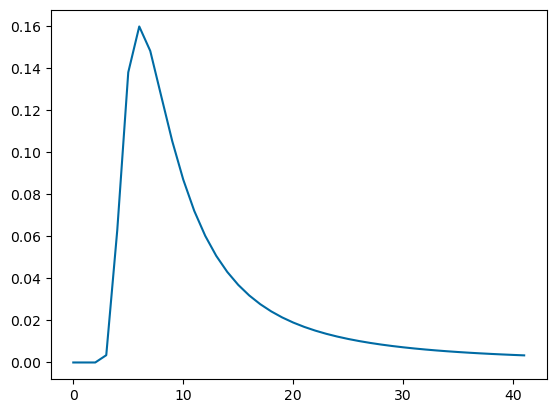

In [5]:
fp = 0.25
Hs = 1

f1 = fp/7
nfreq = int(fp*6/f1)
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

efth = wot.waves.omnidirectional_spectrum(f1, 
                                        nfreq, 
                                        lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp = fp, hs= Hs), 
                                        "Pierson-Moskowitz")
waves = wot.waves.long_crested_wave(efth, 1, seed=42)
plt.plot(np.abs(waves.squeeze()))

In [6]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# create mesh object for WaveBot and add internal lid
mesh_obj = load_from_meshio(mesh, 'WaveBot')
lid_mesh = mesh_obj.generate_lid(-2e-2)

fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")

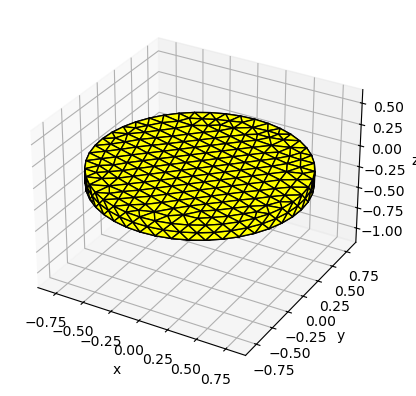

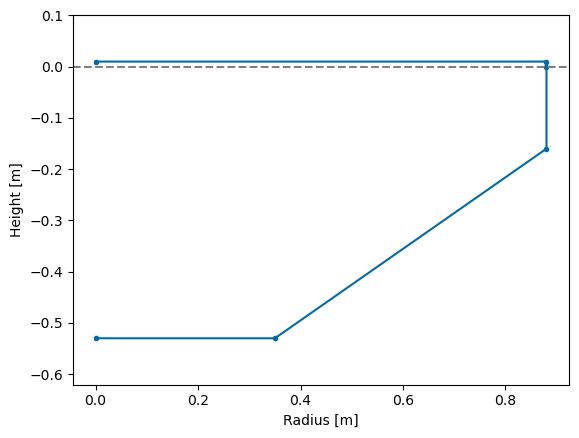

In [7]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True) # specific to WaveBot

In [8]:
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

In [9]:
fname_string = 'bem_wavebot_f1_'+ str.replace(f'{f1}','.','p') +'Hz_nfreq'+ f'{nfreq}' +'.nc'
fname_wec = os.path.join(results_dir, fname_string)
fname_bem = 'wavebot_loss'
if os.path.exists(fname_wec):
    bem_data = wot.read_netcdf(fname_wec)
else:
    bem_data = wot.run_bem(fb, freq)
    wot.write_netcdf(fname_wec, bem_data)


[17:34:51] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

           WARNING  FloatingBody has no inertia_matrix field. If the FloatingBody mass is defined, it will be used 
                    for calculating the inertia matrix here. Otherwise, the neutral buoyancy assumption will be    
                    used to auto-populate.

           WARNING  FloatingBody has no hydrostatic_stiffness field. Capytaine will auto-populate the hydrostatic  
                    stiffness based on the provided mesh.

The resolution of the mesh might be insufficient for omega ranging from 8.752 to 9.425.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 8 problems:                                                                
                    The resolution of the mesh might be insufficient for omega ranging from 8.752 to 9.425.        
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()

Next, we use the utilities class `wecopttool.utilities`, which has functions that help you analyze and design WECs, but are not needed for the core function of WecOptTool.
For example, we calculate the WEC's intrinsic impedance with its hydrodynamic coefficients and inherent inertial properties. We make use of `wecopttool.add_linear_friction()` to convert the `bem_data` into a dataset which contains all zero friction data, because `wecopttool.check_radiation_damping()` and `wecopttool.hydrodynamic_impedance()` excpect a data variable called 'friction'.

The intrinsic impedance tells us how a hydrodynamic body responds to different excitation frequencies. For oscillating systems we are intersted in both, the amplitude of the resulting velocity as well as the phase between velocity and excitation force. Bode plots are useful tool to visualize the frequency response function.

The natural frequency reveals itself as a trough in the intrinsic impedance for restoring degrees of freedom (heave, roll, pitch).

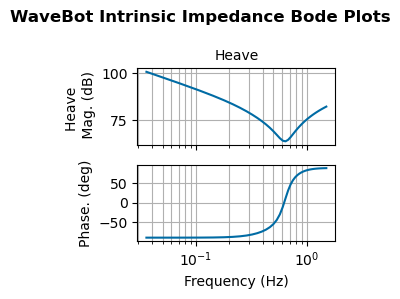

In [10]:
hd = wot.add_linear_friction(bem_data, friction = None) 
#we're not actually adding friction, but need the datavariables in hd 
hd = wot.check_radiation_damping(hd)

intrinsic_impedance = wot.hydrodynamic_impedance(hd)
fig, axes = wot.utilities.plot_bode_impedance(intrinsic_impedance,
                                              'WaveBot Intrinsic Impedance')

In [11]:
def Ploss(flow, effort):
    #based on torque, and angular vel, with R-^2 = 0.991
    eff_max = 250.3983 #max torque in Nm
    flow_max = 9.374 #rotational vel in rad/s
  
    k02 =     0.05824  
    k20 =      0.3622  
    k22 =     0.07884 
    k00 =     0.01669

    Ploss = [(k00 
               + k02*flo**2
               + k20*eff**2 
               + k22*flo**2*eff**2) * eff_max*flow_max
            for eff,flo in
             zip(np.abs(effort)/eff_max,np.abs(flow)/flow_max) ]
    Ploss = np.array(Ploss)
    return Ploss

In [12]:
def Ploss_translatory_space(flow, effort):
    #based on force, and anlinear velocity, with R^2 = 0.991
    eff_max = 3121.6251 #max force in N
    flow_max = 0.75198 # vel in m/s
  
    k02 =     0.05715  
    k20 =      0.3615  
    k22 =     0.07976  
    k00 =     0.01729  

    Ploss = [(k00 
               + k02*flo**2
               + k20*eff**2 
               + k22*flo**2*eff**2) * eff_max*flow_max
            for eff,flo in
             zip(np.abs(effort)/eff_max,np.abs(flow)/flow_max) ]
    Ploss = np.array(Ploss)
    return Ploss

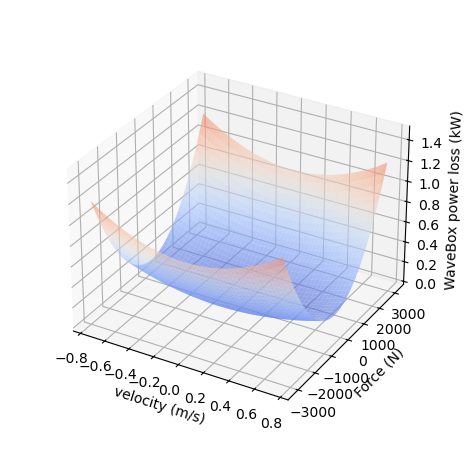

In [13]:
from matplotlib import cm

velocity = np.linspace(-0.75, 0.75, 50)
force = np.linspace(-3121, 3121, 50)
X, Y = np.meshgrid(velocity, force)
P_loss_max = 1.5
# fig, axes = plt.subplots('projec')
ax = plt.figure().add_subplot(projection='3d')
fig.tight_layout()
Z = Ploss_translatory_space(X, Y).copy()/1e3
surf = ax.plot_surface(X, Y, Z, 
                       cmap=cm.coolwarm,
                       linewidth=0, alpha = 0.6,
                       vmin = 0, vmax = P_loss_max)
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('Force (N)')
ax.set_zlabel('WaveBox power loss (kW)')
plt.tight_layout()
ax.set_zlim([0, P_loss_max])
ax.set_box_aspect(None, zoom=0.85)

In [14]:
## PTO impedance definition
# omega = bem_data.omega.values
gear_ratio = 12.4666
torque_constant = 6.7
winding_resistance = 0.5
# winding_inductance = 0.0
# drivetrain_inertia = 2.0
drivetrain_friction = 1.0
# drivetrain_stiffness = 0.0

# drivetrain_impedance = (1j*omega*drivetrain_inertia + 
#                         drivetrain_friction + 
#                         1/(1j*omega)*drivetrain_stiffness) 


# pto_trans_22 =  (1/gear_ratio+0j) * np.ones(omega.shape)
# pto_trans_21 =  gear_ratio* drivetrain_impedance
# pto_trans_12 =  np.zeros(omega.shape)
# pto_trans_11 =  (gear_ratio+0j) * np.ones(omega.shape)

# pto_transmission = np.array([[pto_trans_11, pto_trans_12],
#                             [pto_trans_21, pto_trans_22]])
# pto_transmission.shape

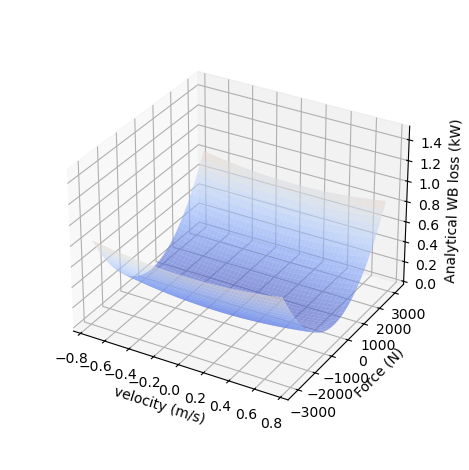

In [56]:
velocity = np.linspace(-0.75, 0.75, 50)
force = np.linspace(-3121, 3121, 50)
X, Y = np.meshgrid(velocity, force)
P_loss_max = 1.5
# fig, axes = plt.subplots('projec')
ax = plt.figure().add_subplot(projection='3d')
Z = ((drivetrain_friction*gear_ratio**2)*X**2 + winding_resistance/(gear_ratio*torque_constant)**2*Y**2)/1e3
surf = ax.plot_surface(X, Y, Z, 
                       cmap=cm.coolwarm,
                       linewidth=0, alpha = 0.6,
                       vmin = 0, vmax = P_loss_max)
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('Force (N)')
ax.set_zlabel('Analytical WB loss (kW)')
ax.set_zlim([0, P_loss_max])
plt.tight_layout()
ax.set_box_aspect(None, zoom=0.85)

In [16]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
# controller = None
# controller = wot.pto.controller_pi
controller = wot.pto.controller_p

#rotary loss
# loss = Ploss
# # pto_impedance = None
# pto_transmission = pto_transmission
# pto = wot.pto.PTO_abcd(ndof, kinematics, controller, pto_transmission, loss, name)

#translatory loss
loss = Ploss_translatory_space
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

In [17]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}


constraints = []

#### `WEC` creation
We are now ready to create the `WEC` object itself!
Since we ran the BEM already, we can define the object using the `wecopttool.WEC.from_bem` function.
If we saved BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [18]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

_Note: You may receive a warning regarding negative linear damping values._
_By default, WecOptTool ensures that the BEM data does not contain non-negative damping values._
_If you would like to correct the BEM solution to a different minimum damping value besides zero, you can specify_ `min_damping`.

### Objective function
The objective function is the quantity we want to optimize—in this case, the average mechanical power.
The function to compute this can be taken directly from the `PTO` object we created:

In [19]:
obj_fun = pto.average_power

The objective function is itself a function of the optimization state `x_opt`.
The length of `x_opt`, `nstate_opt`, needs to be properly defined to successfully call `scipy.optimize.minimize`.
In other words, it should match the quantities we are interested in optimizing.
In this case, we are optimizing for the control trajectories of an unstructured PTO, which can be represented in the Fourier domain by the DC (zero frequency) component, then the real and imaginary components for each frequency.

In [20]:
nstate_opt = 2*nfreq

One technical quirk here: `nstate_opt` is one smaller than would be expected for a state space representing the mean (DC) component and the real and imaginary Fourier coefficients.
This is because WecOptTool excludes the imaginary Fourier component of the highest frequency (the 2-point wave).
Since the 2-point wave is sampled at multiples of $\pi$, the imaginary component is evaluated as $sin(n\pi); n = 0, 1, 2, ..., n_{freq}$, which is always zero.

### Solve
We are now ready to solve the problem.
WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

The only required inputs for defining and solving the problem are:

1. The wave environment
2. The objective function
3. The size of the optimization state (`nstate_opt`)

Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance.
See the `scipy.optimize.minimize` documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for more details.

To help the problem converge faster, we will scale the problem before solving it (see the [Scaling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) section of the Theory documentation).
WecOptTool allows you to scale the WEC dynamics state, the optimization state, and the objective function separately.
See the `wecopttool.WEC.solve` documentation [here](https://sandialabs.github.io/WecOptTool/api_docs/wecopttool.WEC.solve.html#wecopttool-wec-solve).


Pay attention to the `Exit mode`: an exit mode of `0` indicates a successful solution.
A simple problem (linear, single degree of freedom, unconstrained, etc.) should converge in well under 100 iterations.
If you exceed this, try adjusting the scales by orders of magnitude, one at a time.

In [21]:
options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_average_power = results[0].fun
print(f'Optimal average power: {opt_average_power} W')

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.915239351043068
            Iterations: 20
            Function evaluations: 25
            Gradient evaluations: 20
Optimal average power: -291.5239351043068 W


### Analyzing results
We will use two post-processing functions to obtain frequency and time domain results for the WEC and PTO responses.
The `wec.post_process` and `pto.post_process` functions both post-process the results for each wave phase realization.
The pseudo-spectral method gives continuous in time results.
To get smoother looking plots, we specify five subpoints betweeen co-location points.

In [22]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

The `pto.post_process` function returns a list of `xarray.Dataset` objects, each element of which has built-in integration with PyPlot for smart plotting with automatic titles and formatting.
We will plot the mechanical power (`mech_power`), position (`pos`), and the PTO force (`force`).

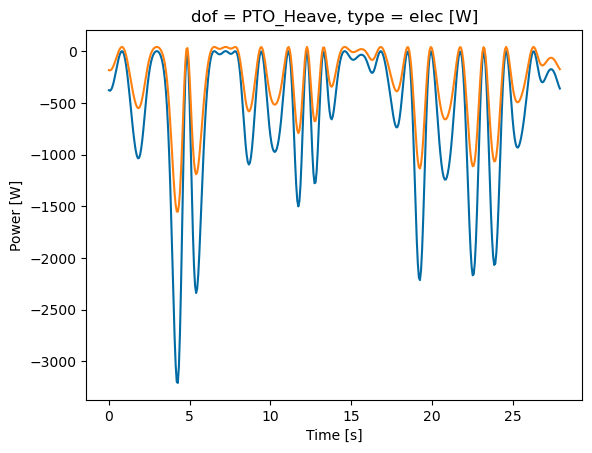

In [23]:
plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()
pto_tdom[0]['power'].loc['elec',:,:].plot()

We could similarly plot any time or frequency domain response of the WEC or PTO by calling the specific type of response (position, velocity, force, etc.).
For example, to plot the WEC heave position and PTO force:

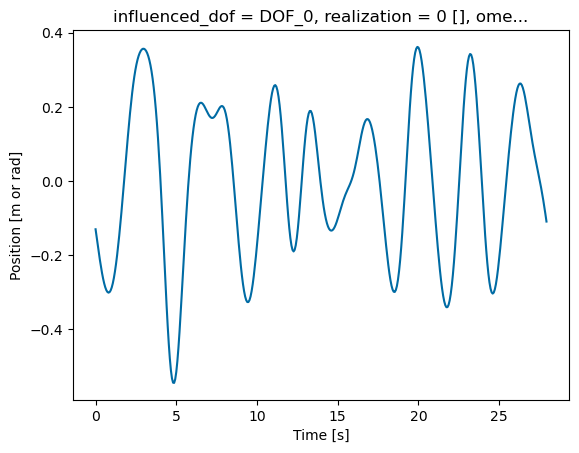

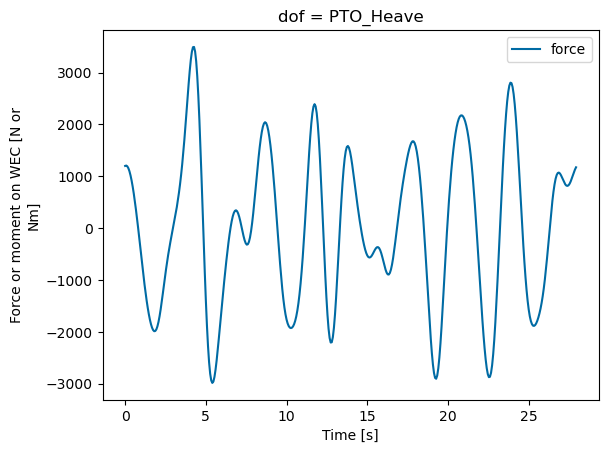

In [24]:
plt.figure()
wec_tdom[0]['pos'].plot()

plt.figure()
pto_tdom[0]['force'].plot(label = 'force')
# pto_tdom[0]['trans_eff'].plot(label = 'torque')
plt.legend()

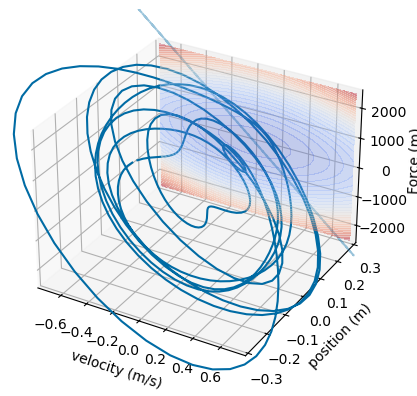

In [25]:
# fig,_ = plt.subplots()
# ax= fig.add_subplot(projection='3d')

def plot_phase_space(pto_tdom, Ploss_translatory_space):
    ax = plt.figure().add_subplot(projection='3d')

    ylim = [-0.3, 0.3]
    xlim = [-0.75, 0.75]
    zlim = [-2500, 2500]


    ax.plot(pto_tdom[0]['vel'], pto_tdom[0]['pos'], pto_tdom[0]['force'], color = 'C0')
    # ylim = ax.get_ylim()
    ax.plot(pto_tdom[0]['vel'], ylim[1]*np.ones_like(pto_tdom[0]['pos']), pto_tdom[0]['force'], linestyle = '--', color = 'C0', alpha = 0.4)


    # xlim = ax.get_xlim()
    # zlim = ax.get_zlim()
    X, Z = np.meshgrid(np.linspace(xlim[0], xlim[1] , 30), 
                    np.linspace(zlim[0], zlim[1] , 30))
    Y= Ploss_translatory_space(X, Z).copy()/1e3

    contour = ax.contourf(X, Y, Z, zdir='y', offset= ylim[1],cmap=cm.coolwarm, vmin = 0,
                                    vmax = np.max(Y), alpha = 0.3, levels = 30)

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_zlim(zlim)


    ax.set_xlabel('velocity (m/s)')
    ax.set_ylabel('position (m)')
    ax.set_zlabel('Force (m)')
plot_phase_space(pto_tdom, Ploss_translatory_space)

Text(0.5, 0, 'Force (m)')

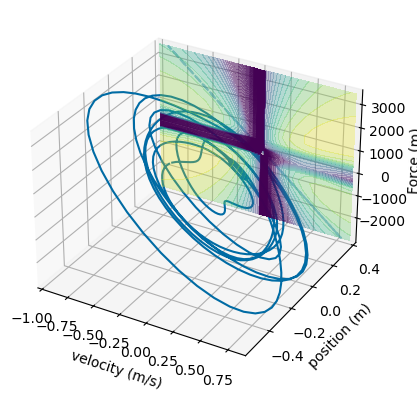

In [26]:
# fig,_ = plt.subplots()
# ax= fig.add_subplot(projection='3d')
ax = plt.figure().add_subplot(projection='3d')

ax.plot(pto_tdom[0]['vel'], pto_tdom[0]['pos'], pto_tdom[0]['force'], color = 'C0')
ylim = ax.get_ylim()
ax.plot(pto_tdom[0]['vel'], ylim[1]*np.ones_like(pto_tdom[0]['pos']), pto_tdom[0]['force'], linestyle = '--', color = 'C0', alpha = 0.4)


xlim = ax.get_xlim()
zlim = ax.get_zlim()
X, Z = np.meshgrid(np.linspace(xlim[0], xlim[1] , 50), 
                   np.linspace(zlim[0], zlim[1] , 20))
Pm = X*Z
Pl = Ploss_translatory_space(X, Z).copy()
Eff = (Pl + Pm)**(-1*np.sign(Pm)) *Pm**np.sign(Pm) * np.sign(Pm)**2  #global


Y= Eff
contour = ax.contourf(X, Y, Z, zdir='y', offset= ylim[1],cmap=cm.viridis, vmin = 0,
                                 vmax = 0.75, alpha = 0.3, levels = 1000)

ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('position (m)')
ax.set_zlabel('Force (m)')



<xarray.DataArray 'vel' (influenced_dof: 1, time: 420)>
array([[-3.58353449e-01, -3.74854483e-01, -3.84343591e-01,
        -3.85652254e-01, -3.78086788e-01, -3.61525726e-01,
        -3.36419277e-01, -3.03679703e-01, -2.64488672e-01,
        -2.20077472e-01, -1.71546434e-01, -1.19776454e-01,
        -6.54520716e-02, -9.17427413e-03,  4.83927176e-02,
         1.06409658e-01,  1.63841240e-01,  2.19545811e-01,
         2.72450211e-01,  3.21745757e-01,  3.67025422e-01,
         4.08296376e-01,  4.45842974e-01,  4.79969633e-01,
         5.10701674e-01,  5.37546929e-01,  5.59411109e-01,
         5.74716741e-01,  5.81712041e-01,  5.78893076e-01,
         5.65421584e-01,  5.41416450e-01,  5.08031656e-01,
         4.67296683e-01,  4.21766180e-01,  3.74080771e-01,
         3.26561887e-01,  2.80944086e-01,  2.38295952e-01,
         1.99114350e-01,  1.63520169e-01,  1.31456683e-01,
         1.02803222e-01,  7.73615614e-02,  5.47327674e-02,
         3.41543087e-02,  1.43903498e-02, -6.24779787e-03,
        -2.97241385e-02, -5.79819515e-02, -9.26229928e-02,
        -1.34676982e-01, -1.84551856e-01, -2.42189761e-01,
        -3.07368696e-01, -3.80016259e-01, -4.60370385e-01,
        -5.48850480e-01, -6.45589177e-01, -7.49697124e-01,
...
        -9.21893556e-01, -8.95736742e-01, -8.41912439e-01,
        -7.61284778e-01, -6.57186516e-01, -5.35086535e-01,
        -4.01865764e-01, -2.64872329e-01, -1.30967348e-01,
        -5.75760986e-03,  1.06852149e-01,  2.04745945e-01,
         2.87372728e-01,  3.55329309e-01,  4.09892632e-01,
         4.52624914e-01,  4.85122764e-01,  5.08915869e-01,
         5.25465168e-01,  5.36182255e-01,  5.42398236e-01,
         5.45246162e-01,  5.45471219e-01,  5.43227557e-01,
         5.37943053e-01,  5.28324781e-01,  5.12541207e-01,
         4.88564470e-01,  4.54605619e-01,  4.09544240e-01,
         3.53251943e-01,  2.86736930e-01,  2.12084727e-01,
         1.32222319e-01,  5.05729319e-02, -2.93150593e-02,
        -1.04091842e-01, -1.70839672e-01, -2.27211096e-01,
        -2.71497628e-01, -3.02667842e-01, -3.20406416e-01,
        -3.25162618e-01, -3.18189178e-01, -3.01533218e-01,
        -2.77938982e-01, -2.50639999e-01, -2.23050207e-01,
        -1.98398125e-01, -1.79372221e-01, -1.67849712e-01,
        -1.64762401e-01, -1.70117535e-01, -1.83150676e-01,
        -2.02555167e-01, -2.26719537e-01, -2.53914079e-01,
        -2.82396295e-01, -3.10440927e-01, -3.36330283e-01]])
Coordinates:
  * influenced_dof  (influenced_dof) <U5 'DOF_0'
    realization     int32 0
  * time            (time) float64 0.0 0.06667 0.1333 0.2 ... 27.8 27.87 27.93
    omega           float64 9.425
    freq            float64 1.5
    period          float64 0.6667
Attributes:
    long_name:  Velocity
    units:      m/s or rad/s

In [65]:
wec_tdom[0].force.sel(type = 'radiation')

<xarray.DataArray 'force' (influenced_dof: 1, time: 420)>
array([[ 2.89592788e+02,  2.46169969e+02,  1.82005921e+02,
         9.75135662e+01, -5.06148306e+00, -1.21534155e+02,
        -2.46261007e+02, -3.73096971e+02, -4.96519126e+02,
        -6.12528693e+02, -7.19014427e+02, -8.15461074e+02,
        -9.02139514e+02, -9.79121107e+02, -1.04553281e+03,
        -1.09937666e+03, -1.13800750e+03, -1.15908308e+03,
        -1.16158287e+03, -1.14642792e+03, -1.11636167e+03,
        -1.07503173e+03, -1.02554460e+03, -9.69019750e+02,
        -9.03738732e+02, -8.25326527e+02, -7.28057191e+02,
        -6.06962433e+02, -4.60089818e+02, -2.90137688e+02,
        -1.04845111e+02,  8.41011628e+01,  2.63391060e+02,
         4.20970677e+02,  5.48596399e+02,  6.43279469e+02,
         7.07207385e+02,  7.46246232e+02,  7.67608832e+02,
         7.77542883e+02,  7.79851061e+02,  7.75715052e+02,
         7.64782763e+02,  7.46984855e+02,  7.24261881e+02,
         7.01419890e+02,  6.85682547e+02,  6.85041797e+02,
         7.06020279e+02,  7.51740745e+02,  8.21124275e+02,
         9.09617402e+02,  1.01122382e+03,  1.12102555e+03,
         1.23706301e+03,  1.36055829e+03,  1.49401294e+03,
         1.63752765e+03,  1.78449391e+03,  1.91829434e+03,
...
         9.51216740e+02,  4.83976454e+02, -6.18858388e+00,
        -4.89879965e+02, -9.38338703e+02, -1.32745556e+03,
        -1.64064613e+03, -1.87014887e+03, -2.01668881e+03,
        -2.08780211e+03, -2.09535977e+03, -2.05292025e+03,
        -1.97347599e+03, -1.86797235e+03, -1.74472626e+03,
        -1.60962503e+03, -1.46680393e+03, -1.31942614e+03,
        -1.17023032e+03, -1.02165076e+03, -8.75505405e+02,
        -7.32429080e+02, -5.91346318e+02, -4.49292343e+02,
        -3.01795615e+02, -1.43857766e+02,  2.86386954e+01,
         2.17432213e+02,  4.20704094e+02,  6.32580799e+02,
         8.43512656e+02,  1.04149339e+03,  1.21385580e+03,
         1.34922393e+03,  1.43916950e+03,  1.47922088e+03,
         1.46907156e+03,  1.41206736e+03,  1.31424017e+03,
         1.18324113e+03,  1.02748514e+03,  8.55672163e+02,
         6.76659630e+02,  4.99497306e+02,  3.33364357e+02,
         1.87195258e+02,  6.89274915e+01, -1.55077280e+01,
        -6.31756358e+01, -7.47760287e+01, -5.46656169e+01,
        -1.01770222e+01,  4.96315291e+01,  1.15475284e+02,
         1.79189041e+02,  2.34574949e+02,  2.77582683e+02,
         3.05884762e+02,  3.18112874e+02,  3.13120133e+02]])
Coordinates:
  * influenced_dof  (influenced_dof) <U5 'DOF_0'
    realization     int32 0
  * time            (time) float64 0.0 0.06667 0.1333 0.2 ... 27.8 27.87 27.93
    omega           float64 9.425
    freq            float64 1.5
    period          float64 0.6667
    type            <U9 'radiation'
Attributes:
    long_name:  Force or moment
    units:      N or Nm

In [28]:
Pl_traj = Ploss_translatory_space(pto_tdom[0]['vel'], pto_tdom[0]['force']).copy()
# Pl_traj = Ploss(pto_tdom[0]['trans_flo'], pto_tdom[0]['trans_eff']).copy()

Pe_traj = pto_tdom[0]['power'].sel(type = 'elec')
Pm_traj = pto_tdom[0]['power'].sel(type = 'mech')
Pexc_traj = wec_tdom[0].force.sel(type=['Froude_Krylov', 'diffraction']).sum('type')*wec_tdom[0]['vel']
Eff_traj = (Pl_traj + Pm_traj)**(-1*np.sign(Pm_traj)) *Pm_traj**np.sign(Pm_traj) * np.sign(Pm_traj)**2  #global
np.mean(Eff_traj), np.mean(Pe_traj)/np.mean(Pm_traj)

(<xarray.DataArray 'power' ()>
 array(-26.24474814)
 Coordinates:
     type     <U4 'mech',
 <xarray.DataArray 'power' ()>
 array(0.4930628))

Text(0, 0.5, 'Power [W] \n negative power is taking out of system, \n i.e. generating')

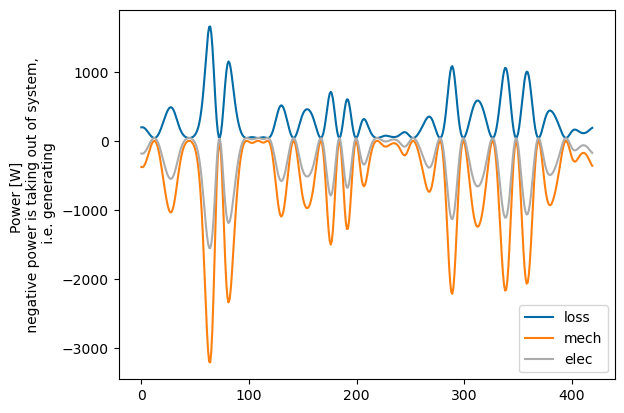

In [29]:
plt.plot(Pl_traj, label = 'loss')
plt.plot(Pm_traj, label = 'mech')
plt.plot(Pe_traj, label = 'elec')

plt.legend()
plt.ylabel('Power [W] \n negative power is taking out of system, \n i.e. generating')
# plt.plot(Pe_traj-Pm_traj, ':')



Text(0, 0.5, 'Force (N)')

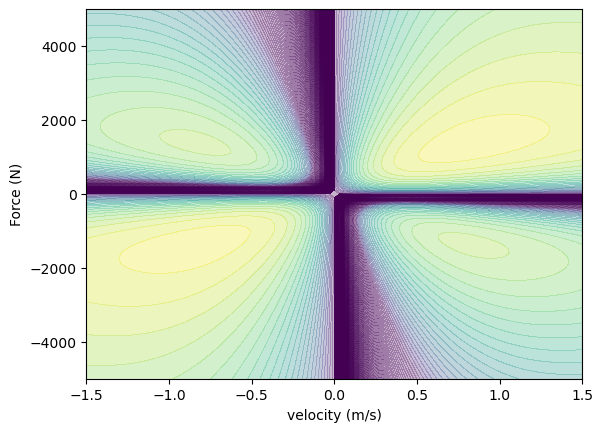

In [30]:
velocity = np.linspace(-1.5, 1.5, 101)
force = np.linspace(-5000, 5000, 101)

# velocity = np.linspace(0.1, 0.75, 50)
# force = np.linspace(0, 3121, 50)

X, Y = np.meshgrid(velocity, force)


X, Y = np.meshgrid(velocity, force)


# ax = plt.figure().add_subplot(projection='3d')
ax = plt.figure().add_subplot()
Pm = X*Y
Pl = Ploss_translatory_space(X, Y).copy()
# Eff = Pm/(Pl + Pm)  #for motoring
# Eff = (Pl + Pm)/Pm  #for generating
Eff = (Pl + Pm)**(-1*np.sign(Pm)) *Pm**np.sign(Pm) * np.sign(Pm)**2  #global

# Eff = Eff[Eff > -1]
# surf = ax.plot_surface(X, Y, Eff, 
#                        cmap=cm.viridis,
#                        linewidth=0, alpha = 0.6,  vmin = 0.1, vmax= 0.6)

ax.contourf(X, Y, Eff, cmap=cm.viridis, vmin = 0,
                                 vmax = 0.75, alpha = 0.3, levels = 500,  linestyles = None)                    
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('Force (N)')
# ax.set_zlim([0, 1])

Note that there are other dynamic responses available in the post-processed WEC and PTO variables (`wec_tdom`, `pto_tdom`, `wec_fdom`, `pto_fdom`).
For example, the time domain PTO variable contains the following response:

Lastly, we will visualize the average power at different stages and how the power flows through the system.


Text(0.5, 0, 'Force (m)')

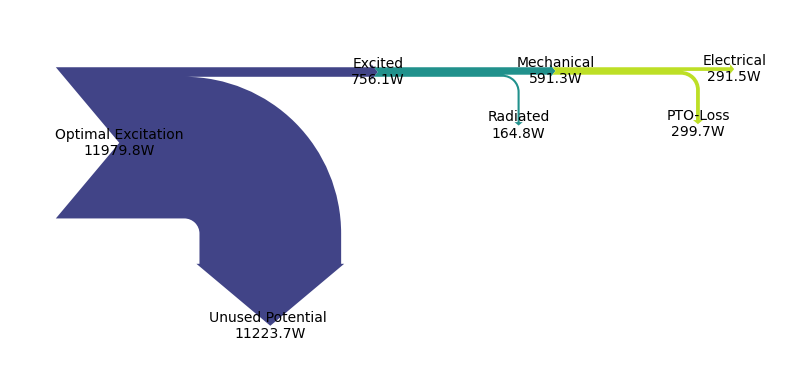

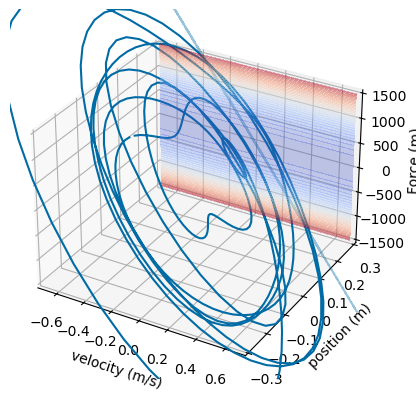

In [31]:
import matplotlib.gridspec as gridspec
p_flows = wot.utilities.calculate_power_flows(wec,
                                              pto, 
                                              results, 
                                              waves, 
                                              intrinsic_impedance)
fig, ax1 = wot.utilities.plot_power_flow(p_flows)

xlim = [-0.71, 0.71]#ax.get_xlim()
ylim = [-0.3, 0.3]#ax.get_ylim()
zlim = [-1500, 1500]#ax.get_zlim()

ax = plt.figure().add_subplot(projection='3d')

ax.plot(pto_tdom[0]['vel'], ylim[1]*np.ones_like(pto_tdom[0]['pos']), pto_tdom[0]['force'], linestyle = '--', color = 'C0', alpha = 0.4)
ax.plot(pto_tdom[0]['vel'], pto_tdom[0]['pos'], pto_tdom[0]['force'], color = 'C0')




X, Z = np.meshgrid(np.linspace(xlim[0], xlim[1] , 30), 
                   np.linspace(zlim[0], zlim[1] , 30))
Y= Ploss(X, Z).copy()/1e3

contour = ax.contourf(X, Y, Z, zdir='y', offset= ylim[1],cmap=cm.coolwarm, vmin = 0,
                                 vmax = np.max(Y), alpha = 0.3, levels = 30)

ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_zlim(zlim)
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('position (m)')
ax.set_zlabel('Force (m)')

In [32]:
#need to make all power flows positive and some more for reference
def flip_sign_dict(input_dict):
    """Returns a new dictionary with all values made positive."""
    return {key: -1*value for key, value in input_dict.items()}

def powerflows_wot_to_wam(p_flows):
    power_flows = flip_sign_dict(p_flows)

    power_flows['Pinmax'] = power_flows['Optimal Excitation']/2
    power_flows['Not Absorbed'] =  (
        power_flows['Pinmax'] 
        - power_flows['Absorbed']
            )
    power_flows['Additional Radiation'] =  (
        power_flows['Unused Potential'] 
        - power_flows['Not Absorbed']
            )
    return power_flows
power_flows = powerflows_wot_to_wam(p_flows)

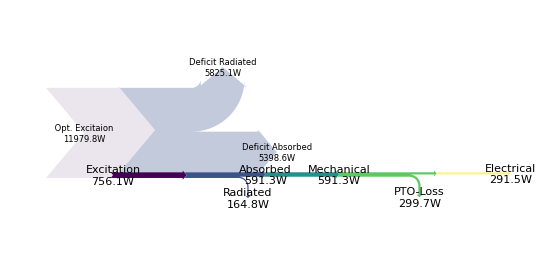

In [33]:
dummy_wavebot_as_multiport =  wam.WEC(omega=bem_data['omega'].values,
            N=12.4666,
            Kt=6.1745,
            Rw=0.5,
            Lw=0,
            Jd=2,
            Bd=1,
            Kd=0,
            Zi=np.squeeze(wot.hydrodynamic_impedance(wot.add_linear_friction(bem_data))).values,
            Hexc=np.squeeze(bem_data['excitation_force'].values))
#add additional radiatiomn
dummy_wavebot_as_multiport.plot_power_flow_total(power_flows)

In [34]:
# from matplotlib.sankey import Sankey

# def plot_power_flow_total(self, power_flows: dict[str, float], sup_title = '', fig = None, axes = None):
#         """Plot power flow through a WEC as Sankey diagram.

#         Parameters
#         ----------
#         power_flows
#             Power flow dictionary produced by for example by
#             :py:func:`wecopttool.utilities.calculate_power_flows`.
#             Required keys: 'Optimal Excitation', 'Radiated', 'Actual Excitation'
#             'Electrical (solver)', 'Mechanical (solver)',
#             'Absorbed', 'Unused Potential', 'PTO Loss'
#         """
#         # fig = plt.figure(figsize = [8,4])
#         # ax = fig.add_subplot(1, 1, 1,)

#         clrs = self.colors

#         # fig = None
#         if axes is None:
#             fig, axes = plt.subplots(nrows = 1, ncols= 1,
#                     # tight_layout=True, 
#                     sharex= True,
#                     figsize= np.array(wam.figsize())*np.array([2,1.5]), 
#                     )
#         len_trunk = 1.0
#         len_trunk = 0.8
#         # plt.viridis()
#         sankey_total = Sankey(ax=axes, 
#                         scale= 1/power_flows['Optimal Excitation'],
#                         offset= 0,
#                         format = '%.1f',
#                         shoulder = 0.02,
#                         tolerance=1e-03*power_flows['Optimal Excitation'],
#                         unit = 'W')
#         sankey_total.add(flows=[power_flows['Optimal Excitation'],
#                     -1*power_flows['Unused Potential'],
#                     -1*power_flows['Actual Excitation']], 
#             labels = [' Opt. Excitaion ', 
#                     '', 
#                     'Excitation'], 
#             orientations=[0, 0,  0],#arrow directions,
#             pathlengths = [0.15,0.15,0.15],
#             trunklength = len_trunk,
#             edgecolor = 'None',
#             facecolor = clrs['hydro'],
#                 alpha = 0.1 #viridis(0.2)
#                 )
#         sankey_total.add(flows=[power_flows['Unused Potential'],
#                     -1*power_flows['Additional Radiation'],
#                     -1*power_flows['Not Absorbed'],], 
#             labels = ['', 
#                     'Deficit Radiated',
#                         'Deficit Absorbed', ], 
#             prior= (0),
#             connect=(1,0),
#             orientations=[0, 1,  0],#arrow directions,
#             pathlengths = [0.15,0.01,0.15],
#             trunklength = len_trunk,
#             edgecolor = 'None',
#             facecolor = clrs['hydro_mech'],
#             alpha = 0.3 #viridis(0.2)
#                 )


#         for sankey, n_diag, cnnct in zip([sankey_total], [2], [2]):

#             #this is new stuff
#             sankey.add(flows=[power_flows['Absorbed'] + power_flows['Radiated'],
#                             -1*(power_flows['Absorbed'] + power_flows['Radiated']),
#                             ], 
#                     labels = ['Excitation', 
#                             'Excitaion'], 
#                     prior= (0),
#                     connect=(cnnct,0),
#                     orientations=[0,  -0],#arrow directions,
#                     pathlengths = [.15,0.15],
#                     trunklength = len_trunk,
#                     edgecolor = 'None',
#                     facecolor = clrs['hydro'] #viridis(0.9)
#             )

#             sankey.add(flows=[
#                     (power_flows['Absorbed'] + power_flows['Radiated']),
#                     -1*power_flows['Radiated'],
#                     -1*power_flows['Absorbed'],
#                     ], 
#                     labels = ['Excitation', 
#                             'Radiated', 
#                             ''], 
#                     # prior= (0),
#                     prior= (n_diag),
#                     connect=(1,0),
#                     orientations=[0, -1,  -0],#arrow directions,
#                     pathlengths = [0.15,0.2,0.15],
#                     trunklength = len_trunk-0.2,
#                     edgecolor = 'None', 
#                     facecolor = clrs['hydro_mech'] #viridis(0.5)
#             )

#             sankey.add(flows=[power_flows['Absorbed'],
#                             -1*power_flows['Mechanical (solver)'],
#                             ], 
#                     labels = ['Absorbed', 
#                             'Mechanical'], 
#                     prior= (n_diag+1),
#                     connect=(2,0),
#                     orientations=[0,  -0],#arrow directions,
#                     pathlengths = [.15,0.15],
#                     trunklength = len_trunk,
#                     edgecolor = 'None',
#                     facecolor = clrs['mech'] #viridis(0.9)
#             )

#             sankey.add(flows=[(power_flows['Mechanical (solver)']),
#                             -1*power_flows['PTO Loss'],
#                             -1*power_flows['Electrical (solver)'],
#                             ], 
#                     labels = ['Mechanical', 
#                             'PTO-Loss' , 
#                             'Electrical'], 
#                     prior= (n_diag+2),
#                     connect=(1,0),
#                     orientations=[0, -1,  -0],#arrow directions,
#                     pathlengths = [.15,0.2,0.15],
#                     trunklength = len_trunk,
#                     edgecolor = 'None',
#                     facecolor = clrs['mech_elec'] #viridis(0.9)
#             )

#             sankey.add(flows=[(power_flows['Electrical (solver)']),
#                         -1*power_flows['Electrical (solver)'],
#                         ], 
#                 labels = ['', 
#                         'Electrical'], 
#                 prior= (n_diag+3),
#                 connect=(2,0),
#                 orientations=[0,  -0],#arrow directions,
#                 pathlengths = [.15,0.15],
#                 trunklength = len_trunk,
#                 edgecolor = 'None',
#                 facecolor = clrs['elec'] #viridis(0.9)
#             )


#             diagrams = sankey.finish()

#             if n_diag ==2 and cnnct == 2:   #case with the reference optimal power
#                 for diagram in diagrams:
#                     for text in diagram.texts:
#                             text.set_fontsize(8)
#                 for diagram in diagrams[0:2]:
#                     for text in diagram.texts:
#                             text.set_fontsize(6)
#                 diagrams[n_diag-2].texts[1].set_text('') 
#                 diagrams[n_diag-2].texts[-1].set_text('') 
#             else:
#                 diagrams[n_diag-1].texts[-1].set_text('') 
#                 for diagram in diagrams:
#                     for text in diagram.texts:
#                             text.set_fontsize(10)

#             diagrams[n_diag-1].texts[0].set_text('') #remove deficit from opt. exci
#             diagrams[n_diag].texts[-1].set_text('') 
#             diagrams[n_diag+1].texts[0].set_text('') #remove exciation from hydro
#             diagrams[n_diag+1].texts[-1].set_text('') #remove absorber from hydro
#             diagrams[n_diag+2].texts[-1].set_text('') #remove mech from hydro-mech
#             diagrams[n_diag+3].texts[-1].set_text('') #remove elec from mech-elec
#             diagrams[n_diag+4].texts[0].set_text('')  #remove elec in from elec

#         fig.suptitle(sup_title)

#         axes.axis("off")
#         # plt.show()
#         if fig is None:
#             return fig, axes, 
# plot_power_flow_total(dummy_wavebot_as_multiport,power_flows)

### make loops with multiple controllers, ptos, wecs, results

In [35]:
controllers = [wot.pto.controller_p, wot.pto.controller_pi, None] # controller = None
controller_names = ['P','PI','Uns']
controller_nstate_opt = [1, 2, 2*nfreq]
ptos = []
wecs = []
results_list = []
pto_tdom_list = []
pflow_list = []
for controller, name, nstate_opt in zip(controllers, controller_names, controller_nstate_opt):
    loss = Ploss_translatory_space
    pto_impedance = None
    pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)
    ptos.append(pto)
    f_add = {'PTO': pto.force_on_wec}

    constraints = []
    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
    )
    wecs.append(wec)
    obj_fun = pto.average_power

    options = {'maxiter': 200}
    scale_x_wec = 1e1
    scale_x_opt = 1e-3
    scale_obj = 1e-2

    res = wec.solve(
        waves, 
        obj_fun, 
        nstate_opt,
        optim_options=options, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
        )
    results_list.append(res[0])
    opt_average_power = res[0].fun
    print(name + f' control. Optimal average power: {opt_average_power} W')
    # x_wec, x_opt = wec.decompost_sate(res[0].x)
    # print(f'x_opt: {x_opt}')
    nsubsteps = 5
    pto_fdom, pto_tdom = pto.post_process(wec, res, waves, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom = wec.post_process(wec, res, waves, nsubsteps=nsubsteps)
    pto_tdom_list.append(pto_tdom)
    p_flows = wot.utilities.calculate_power_flows(wec,
                                              pto, 
                                              res, 
                                              waves, 
                                              intrinsic_impedance)
    pflow_list.append(p_flows)

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.915239351042903
            Iterations: 20
            Function evaluations: 24
            Gradient evaluations: 20
P control. Optimal average power: -291.5239351042903 W


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3173768626292217
            Iterations: 42
            Function evaluations: 49
            Gradient evaluations: 42
PI control. Optimal average power: -331.7376862629222 W


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5447204123171687
            Iterations: 177
            Function evaluations: 256
            Gradient evaluations: 177
Uns control. Optimal average power: -354.47204123171684 W


In [36]:
for wec, res in zip (wecs, results_list):
    x_wec, x_opt = wec.decompose_state(res.x)
    print(f'x_opt: {x_opt}')

x_opt: [-3809.51593019]
x_opt: [-3660.24690157  2726.97379377]
x_opt: [   5.35196058  -14.9122602    27.71002595  -17.72163827   -4.36684459
   39.59796913    8.05695281   72.18047699   25.06079747 -163.53952654
  285.73473057  198.16994218  930.4908359  1167.00491941   21.9014755
 1177.93977383  212.31819604 -717.88715037  838.03169859 -311.87318396
 -800.7856694  -563.7830585  -429.43600063  315.37209311  438.23803581
  266.55822004 -327.64106938  280.05402508   57.31956735 -136.64301985
 -171.84636494 -144.95403817   91.05750322  -28.45984197 -117.86661055
   24.66389513   98.00484208   73.28808344  -20.39691067   -6.95848749
  -64.33825069   36.48519364  -44.26998797  -49.58000941    7.55985116
   44.50657229   40.87131158   41.18979149   11.29769693   43.88364884
  -58.35042391   -6.85666104   36.02435208  -47.30237648   34.36008153
  -57.18707327    6.89944544   -1.72299396   13.47230829   55.0804567
   -3.58617086   42.07754014  -41.92695313    7.80157046    5.81326596
  -42.256

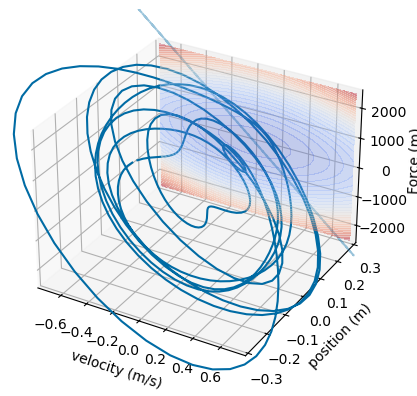

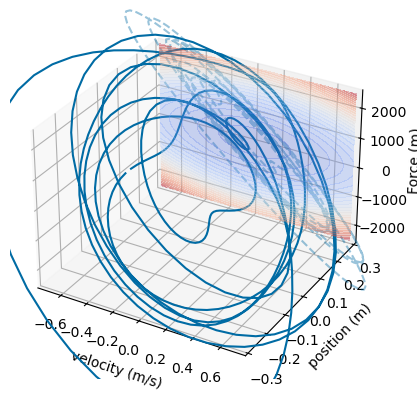

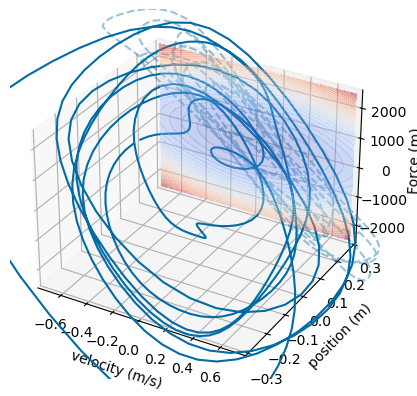

In [37]:
for pto_td in pto_tdom_list:
    plot_phase_space(pto_td, Ploss_translatory_space)

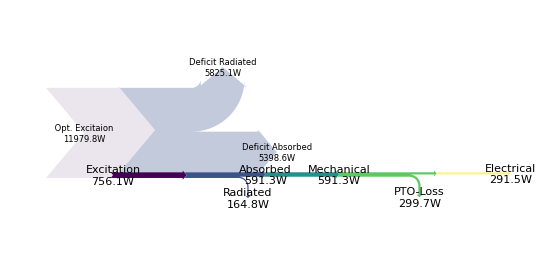

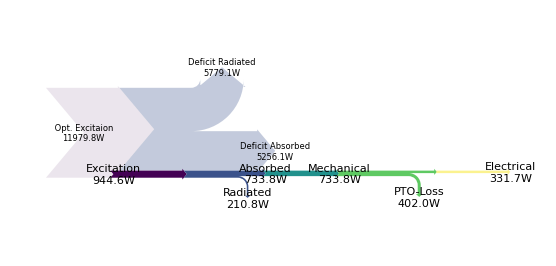

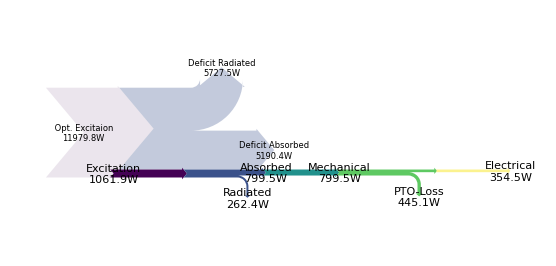

In [38]:
p_excs = []
p_mechs = []
p_elecs = []
for p_flows in pflow_list:
    power_flows = powerflows_wot_to_wam(p_flows)
    p_excs.append(power_flows['Actual Excitation'])
    p_mechs.append(power_flows['Mechanical (solver)'])
    p_elecs.append(power_flows['Electrical (solver)'])
    dummy_wavebot_as_multiport.plot_power_flow_total(power_flows)

In [39]:
wam.figsize()

[3.4592500345925004, 2.1379340969624145]

In [40]:
effs_mech_elec = np.array(p_elecs)/np.array(p_mechs)
effs_excs_elec = np.array(p_elecs)/np.array(p_excs)
effs_excs_mech = np.array(p_mechs)/np.array(p_excs)

In [41]:
dummy_wavebot_as_multiport.colors

{'hydro': (0.267004, 0.004874, 0.329415, 1.0),
 'hydro_mech': (0.229739, 0.322361, 0.545706, 1.0),
 'mech': (0.127568, 0.566949, 0.550556, 1.0),
 'mech_elec': (0.369214, 0.788888, 0.382914, 1.0),
 'elec': (0.974417, 0.90359, 0.130215, 0.5)}

Text(40.20347308703472, 0.5, 'Efficiency ()')

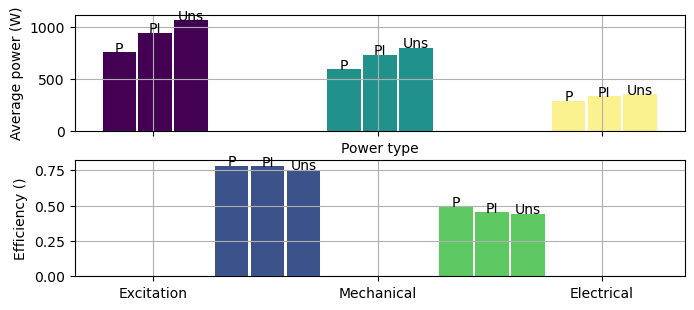

In [42]:


# Sample data
x_labels_pow = ['Excitation', 'Mechanical', 'Electrical']
N = len(controllers)  # Number of bars
bar_width = 0.15  # Width of each bar

fig, axes = plt.subplots(2,1, sharex=True,
                    figsize= np.array(wam.figsize())*np.array([2,1.5]), 
)
plt.tight_layout()
# Create an array of x positions for the bars
x_pos = np.arange(len(x_labels_pow))

# Create the bar positions for each bar
exc_bar_pos = [x_pos[0] + i * (bar_width+0.01)  for i in range(N)]
mech_bar_pos = [x_pos[1] + i * (bar_width+0.01)  for i in range(N)]
elec_bar_pos = [x_pos[2] + i * (bar_width+0.01)  for i in range(N)]

# Create the bar chart
axes[0].bar(exc_bar_pos, p_excs, width=bar_width, label=[controller_names[i] for i in range(N)], color = dummy_wavebot_as_multiport.colors['hydro'])
[axes[0].text(exc_bar_pos[i], p_excs[i], controller_names[i], ha = 'center') for i in range(N)]
axes[0].bar(mech_bar_pos, p_mechs, width=bar_width, label=[controller_names[i] for i in range(N)], color = dummy_wavebot_as_multiport.colors['mech'])
[axes[0].text(mech_bar_pos[i], p_mechs[i], controller_names[i], ha = 'center' ) for i in range(N)]
axes[0].bar(elec_bar_pos, p_elecs, width=bar_width, label=[controller_names[i] for i in range(N)], color = dummy_wavebot_as_multiport.colors['elec'])
[axes[0].text(elec_bar_pos[i], p_elecs[i], controller_names[i], ha = 'center' ) for i in range(N)]
axes[0].grid()

# Add labels and title
axes[0].set_xlabel('Power type')
axes[0].set_ylabel('Average power (W)')
axes[0].set_xticks(x_pos + (N - 1) * bar_width / 2, x_labels_pow)  # Center the x label

x_labels_eff = ['Exc2Mech', 'Mechanical', 'Electrical']

axes[1].bar(np.array(mech_bar_pos) -0.5, effs_excs_mech, width=bar_width,  color = dummy_wavebot_as_multiport.colors['hydro_mech'])
[axes[1].text(np.array(mech_bar_pos[i])-0.5, effs_excs_mech[i], controller_names[i], ha = 'center' ) for i in range(N)]
axes[1].bar(np.array(elec_bar_pos)-0.5, effs_mech_elec, width=bar_width,  color = dummy_wavebot_as_multiport.colors['mech_elec'])
[axes[1].text(np.array(elec_bar_pos[i])-0.5, effs_mech_elec[i], controller_names[i], ha = 'center' ) for i in range(N)]
axes[1].grid()
axes[1].set_ylabel('Efficiency ()')


Text(0.5, 41.2740474219819, 'Efficiency ()')

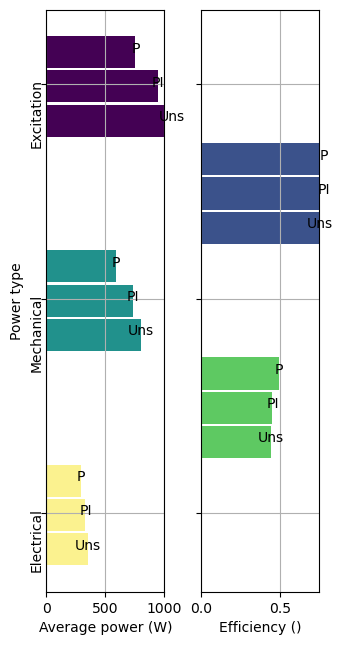

In [43]:
# Sample data
x_labels_pow = ['Electrical', 'Mechanical', 'Excitation']
N = len(controllers)  # Number of bars
bar_width = 0.15  # Width of each bar

fig, axes = plt.subplots(1,2, sharey=True,
                    figsize= np.array(wam.figsize())*np.array([1,3]), 
)
plt.tight_layout()
# Create an array of x positions for the bars
y_pos = np.arange(len(x_labels_pow))

# Create the bar positions for each bar
exc_bar_pos = [y_pos[2] - i * (bar_width+0.01)  for i in range(N)]
mech_bar_pos = [y_pos[1] - i * (bar_width+0.01)  for i in range(N)]
elec_bar_pos = [y_pos[0] - i * (bar_width+0.01)  for i in range(N)]

# Create the bar chart
axes[0].barh(exc_bar_pos, p_excs, height=bar_width, label=[controller_names[i] for i in range(N)], color = dummy_wavebot_as_multiport.colors['hydro'])
[axes[0].text(p_excs[i], exc_bar_pos[i],  controller_names[i], ha = 'center') for i in range(N)]
axes[0].barh(mech_bar_pos, p_mechs, height=bar_width, label=[controller_names[i] for i in range(N)], color = dummy_wavebot_as_multiport.colors['mech'])
[axes[0].text(p_mechs[i],mech_bar_pos[i],  controller_names[i], ha = 'center' ) for i in range(N)]
axes[0].barh(elec_bar_pos, p_elecs, height=bar_width, label=[controller_names[i] for i in range(N)], color = dummy_wavebot_as_multiport.colors['elec'])
[axes[0].text(p_elecs[i], elec_bar_pos[i],  controller_names[i], ha = 'center' ) for i in range(N)]
axes[0].set_xlim([0, 1000])
axes[0].grid()

# # Add labels and title
axes[0].set_ylabel('Power type')
axes[0].set_xlabel('Average power (W)')
axes[0].set_yticks(y_pos -  (N-1)*bar_width/2 , x_labels_pow, rotation=90, ha = 'center')  # Center the x label
# x_labels_eff = ['Exc2Mech', 'Mechanical', 'Electrical']

axes[1].barh(np.array(mech_bar_pos) +0.5, effs_excs_mech, height=bar_width,  color = dummy_wavebot_as_multiport.colors['hydro_mech'])
[axes[1].text(effs_excs_mech[i],np.array(mech_bar_pos[i])+0.5,  controller_names[i], ha = 'center' ) for i in range(N)]
axes[1].barh(np.array(elec_bar_pos)+0.5, effs_mech_elec, height=bar_width,  color = dummy_wavebot_as_multiport.colors['mech_elec'])
[axes[1].text(effs_mech_elec[i],np.array(elec_bar_pos[i])+0.5,  controller_names[i], ha = 'center' ) for i in range(N)]
axes[1].grid()
axes[1].set_xlim([0, 0.75])
# axes[1].set_ylim([0, 2.5])

axes[1].set_xlabel('Efficiency ()')

In [44]:
y_pos, y_pos +  bar_width/2 

(array([0, 1, 2]), array([0.075, 1.075, 2.075]))

In [45]:
x_labels_pow

['Electrical', 'Mechanical', 'Excitation']

In [46]:
np.array(elec_bar_pos)-0.5

array([-0.5 , -0.66, -0.82])

In [47]:
bar_width

0.15

## Experiments with PTO impedance

In [48]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
# drivetrain_inertia = 2.0
drivetrain_inertia = 0.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance_2 = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

In [49]:
## Update PTO
name_2 = ['PTO_Heave_Ex2']
pto_2 = wot.pto.PTO(ndof, kinematics, controller=controller, impedance=pto_impedance_2, loss = None, names= name_2)

constraints_2 = []
f_add_2 = {'PTO': pto_2.force_on_wec}

In [50]:
# Update WEC
wec_2 = wot.WEC.from_bem(bem_data,
                         constraints=constraints_2,
                         friction=None,
                         f_add=f_add_2
)

# Update objective function
obj_fun_2 = pto_2.average_power

# Solve
scale_x_wec = 1e1  
scale_x_opt = 1e-3  
scale_obj = 1e-2  

results_2 = wec_2.solve(
    waves, 
    obj_fun_2, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
opt_average_power = results_2[0].fun
print(f'Optimal average electrical power: {opt_average_power} W')

# Post-process
wec_fdom_2, wec_tdom_2 = wec_2.post_process(wec_2, results_2, waves, nsubsteps)
pto_fdom_2, pto_tdom_2 = pto_2.post_process(wec_2, results_2, waves, nsubsteps)

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.246214852880484
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
Optimal average electrical power: -724.6214852880483 W


In [51]:
loss = pto_tdom[0]['power'].sel(type='elec')- pto_tdom[0]['power'].sel(type='mech')
loss_2 = pto_tdom_2[0]['power'].sel(type='elec')- pto_tdom_2[0]['power'].sel(type='mech')

We will compare our optimal results to the unconstrained case to gain some insight into the effect of the constraint on the optimal PTO force.
Let's do the same process as before, but unset the `constraints` parameter in a new `WEC` object.

Note that the optimal constrained PTO force follows the optimal unconstrained solution (sinusoidal) whenever the unconstrained solution is within the constraint. 
When the constraint is active the optimal PTO force is the maximum PTO force of 750 Newtons.

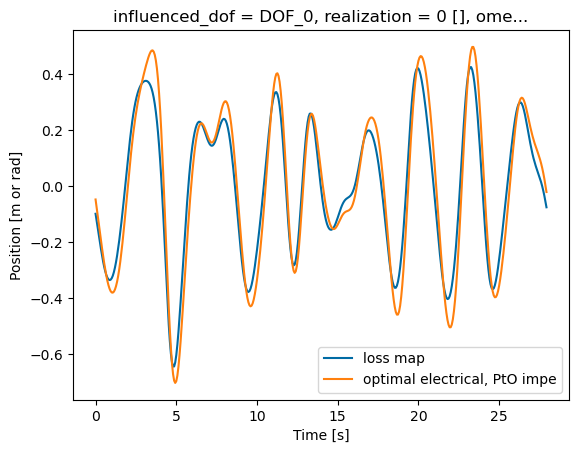

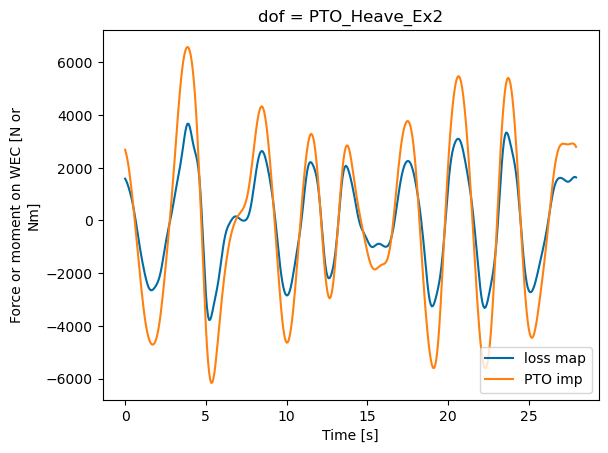

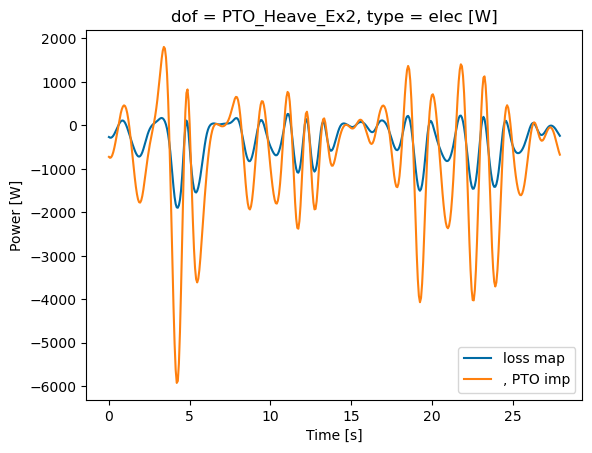

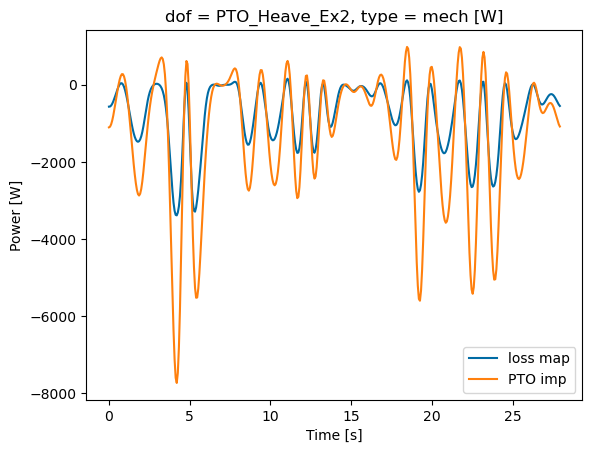

In [52]:
plt.figure()
wec_tdom[0]['pos'].plot(label='loss map')
wec_tdom_2[0]['pos'].plot(label='optimal electrical, PtO impe')
plt.legend(loc='lower right')

plt.figure()
pto_tdom[0]['force'].plot(label='loss map')
pto_tdom_2[0]['force'].plot(label='PTO imp')
plt.legend(loc='lower right')

plt.figure()
pto_tdom[0]['power'].sel(type='elec').plot(label='loss map')
pto_tdom_2[0]['power'].sel(type='elec').plot(label=', PTO imp')
plt.legend(loc='lower right')

plt.figure()
pto_tdom[0]['power'].sel(type='mech').plot(label='loss map')
pto_tdom_2[0]['power'].sel(type='mech').plot(label='PTO imp')
plt.legend(loc='lower right')



[Text(0.5, 0, ''), Text(0.5, 0, '')]

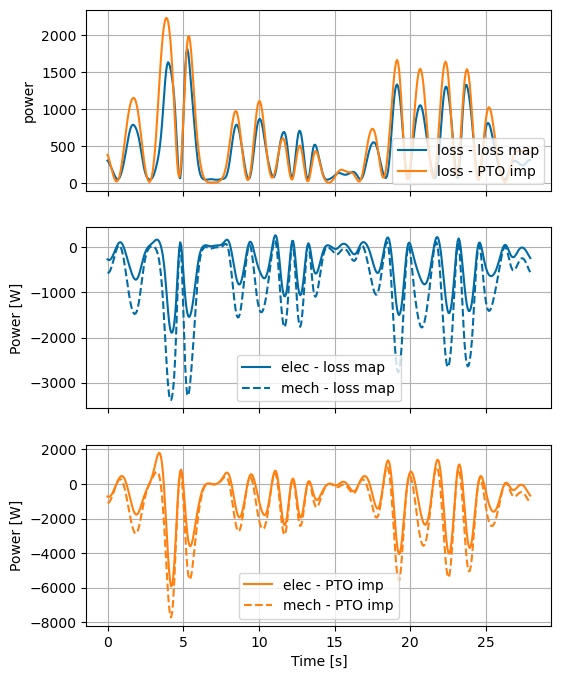

In [53]:
fig, axes = plt.subplots(3,1,
                         sharex= True,
                        #  sharey= True
                         figsize=(6, 8))
loss.plot(ax = axes[0],label='loss - loss map')
loss_2.plot(ax = axes[0],label='loss - PTO imp')
axes[0].legend(loc='lower right')

pto_tdom[0]['power'].sel(type='elec').plot(ax = axes[1],label='elec - loss map', color = 'C0')
pto_tdom[0]['power'].sel(type='mech').plot(ax = axes[1],label='mech - loss map', color = 'C0', linestyle = '--')
axes[1].legend()

pto_tdom_2[0]['power'].sel(type='elec').plot(ax = axes[2],label='elec - PTO imp', color = 'C1')
pto_tdom_2[0]['power'].sel(type='mech').plot(ax = axes[2],label='mech - PTO imp', color = 'C1', linestyle = '--')
axes[2].legend()

[ax.grid() for ax in axes.flatten()]
[ax.set_title('') for ax in axes.flatten()]
[ax.set_xlabel('') for ax in axes[:-1].flatten()]
# axes[2].set_xlim([2, 7])

[Text(0.5, 0, ''), Text(0.5, 0, '')]

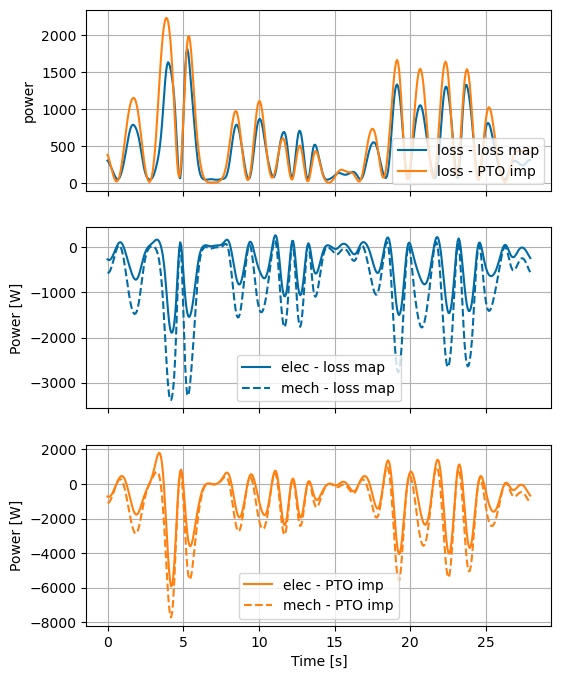

In [54]:
fig, axes = plt.subplots(3,1,
                         sharex= True,
                        #  sharey= True
                         figsize=(6, 8))
loss.plot(ax = axes[0],label='loss - loss map')
loss_2.plot(ax = axes[0],label='loss - PTO imp')
axes[0].legend(loc='lower right')

pto_tdom[0]['power'].sel(type='elec').plot(ax = axes[1],label='elec - loss map', color = 'C0')
pto_tdom[0]['power'].sel(type='mech').plot(ax = axes[1],label='mech - loss map', color = 'C0', linestyle = '--')
axes[1].legend()

pto_tdom_2[0]['power'].sel(type='elec').plot(ax = axes[2],label='elec - PTO imp', color = 'C1')
pto_tdom_2[0]['power'].sel(type='mech').plot(ax = axes[2],label='mech - PTO imp', color = 'C1', linestyle = '--')
axes[2].legend()

[ax.grid() for ax in axes.flatten()]
[ax.set_title('') for ax in axes.flatten()]
[ax.set_xlabel('') for ax in axes[:-1].flatten()]
# axes[2].set_xlim([2, 7])

The attentive user might have noticed that the amplitude of the mechanical power is less compared to Part 1 of the tutorial.
We can see that optimizing for electrical power requires optimal state trajectories with less reactive mechanical power (i.e. power that is put into the system).

The PTO force trajectory for optimizing mechanical power is saturated at the maximum for longer compared to the electrical power.
This could inform the WEC designer optimizing for mechanical power to consider larger components that would not be utilized at their limit as frequently.
However, the electrical power (_not_ the mechanical power) is the usable form of power, thus designing the WEC for optimal electrical power does not indicate a need for larger components and prevents this over-design.

The Sankey power flow diagram confirm this observation.

(<Figure size 800x400 with 1 Axes>, <Axes: >)

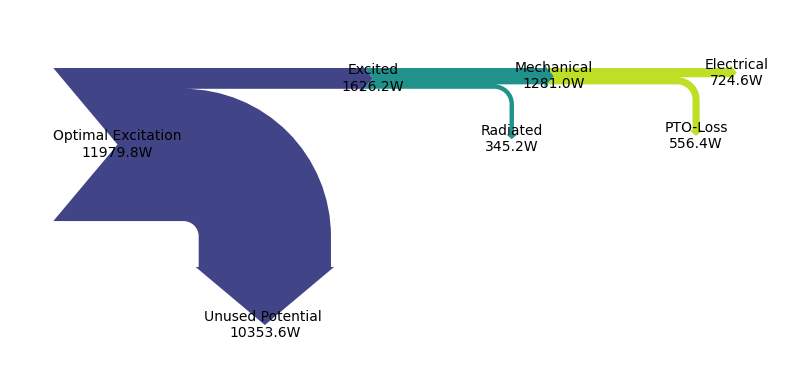

In [55]:
p_flows_2 = wot.utilities.calculate_power_flows(wec_2, pto_2, results_2, waves, intrinsic_impedance)
wot.utilities.plot_power_flow(p_flows_2)